In [1]:
import matplotlib.pyplot as plt
import numpy as np
import optuna
from optuna.samplers import TPESampler
import pandas as pd
import re
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
import warnings
import xgboost as xgb
from xgboost import plot_importance

## Reading in Data

In [2]:
# Read in training and test datasets
x_train = pd.read_csv(
  "../data/processed/x_train_w_OHE.csv", index_col=0, dtype=str
)
x_test = pd.read_csv(
  "../data/processed/x_test_w_OHE.csv", index_col=0, dtype=str
)
y_train = pd.read_csv(
  "../data/processed/y_train.csv", index_col=0, dtype=float
).squeeze("columns").reset_index(drop=True)
y_test = pd.read_csv(
  "../data/processed/y_test.csv", index_col=0, dtype=float
).squeeze("columns").reset_index(drop=True)

# Assign validation set from training set
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42)

In [3]:
# Ensure features are of correct type for modeling
def get_correct_types_x(df, numeric_cols):
    for col in ['deenergize_time', 'restoration_time']:
        df[col] = pd.to_datetime(df[col], format='%Y-%m-%d %H:%M:%S')
    for col in numeric_cols:
        df[col] = df[col].astype(float)
    return df
numeric_cols = [
    'hftd_tier', 'total_affected', 'residential_affected',
    'longitude', 'latitude', 'total_pop', 'median_age', 'median_income',
    'white_pct', 'tmin_d-5', 'tmax_d-5', 'wspd_d-5', 'tmin_d-4', 'tmax_d-4',
    'wspd_d-4', 'tmin_d-3', 'tmax_d-3', 'wspd_d-3', 'tmin_d-2', 'tmax_d-2',
    'wspd_d-2', 'tmin_d-1', 'tmax_d-1', 'wspd_d-1', 'day_in_year'
]

In [4]:
# Scale all numeric columns, leaving categorical columns unchanged
zip_cols = x_train.columns[
    [re.search('zip_is', col) is not None for col in x_train.columns]
]
x_train = get_correct_types_x(x_train, numeric_cols)
x_valid = get_correct_types_x(x_valid, numeric_cols)
x_test = get_correct_types_x(x_test, numeric_cols)
rel_x_train = x_train[numeric_cols]
rel_x_valid = x_valid[numeric_cols]
rel_x_test = x_test[numeric_cols]

scaler = StandardScaler()
scaler.fit(rel_x_train)
scaled_x_train = np.hstack([
    scaler.transform(rel_x_train), np.array(x_train[zip_cols])
])
scaled_x_valid = np.hstack([
    scaler.transform(rel_x_valid), np.array(x_valid[zip_cols])
])
scaled_x_test = np.hstack([
    scaler.transform(rel_x_test), np.array(x_test[zip_cols])
])

## Baseline Model

In [5]:
# Train baseline model with "default" hyperparameters
baseline_params = {'max_depth':6, 'eta':.3, 'objective':'reg:squarederror'}
num_round = 5
baseline_d_train = xgb.DMatrix(scaled_x_train, label = y_train)
xgb_model = xgb.train(baseline_params, baseline_d_train, num_round)
d_test = xgb.DMatrix(scaled_x_test, label = y_test)
baseline_preds = xgb_model.predict(d_test)
print("RMSE = ", np.sqrt(mean_squared_error(baseline_preds, y_test)))

RMSE =  1070.4475962877377


## Optimizing Hyperparameters

In [9]:
# Optimize hyperparameters using optuna over range of possible values
def objective(trial):
    """Define the objective function"""

    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 550),
        'min_child_weight': trial.suggest_int('min_child_weight', 4, 11),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-5, 1.0, log=True),
        'eval_metric': 'mlogloss',
        'use_label_encoder': False
    }

    # Fit the model
    optuna_model = xgb.XGBRegressor(**params)
    optuna_model.fit(scaled_x_train, y_train)

    # Make predictions
    y_valid_pred = optuna_model.predict(scaled_x_valid)

    # Evaluate predictions
    return np.sqrt(mean_squared_error(y_valid_pred, y_valid))

In [10]:
# Create a study to iterate over hyperparameter values
sampler = TPESampler(seed=24)
study = optuna.create_study(sampler=sampler, direction='minimize')

[I 2022-12-05 13:42:21,966] A new study created in memory with name: no-name-e49e7598-d25d-47fe-a120-0252855ce140


In [ ]:
# Examine output of study
study.optimize(objective, n_trials=100)
warnings.filterwarnings('ignore')

print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study.best_trial

print('  RMSE: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

## Fit model with best parameters and predict

In [12]:
# Function to calculate test_R^2 and MAE
def calc_test_r2(pred_vals, true_vals, baseline_rmse):
    sse = mean_squared_error(pred_vals, true_vals) * len(true_vals)
    sst = (baseline_rmse ** 2) * len(true_vals)
    return (
        1 - sse / sst,
        np.sqrt(sse / len(true_vals)),
        mean_absolute_error(pred_vals, true_vals),
        mean_absolute_percentage_error(pred_vals, true_vals)
    )


In [13]:
# Save best parameters, fit a model, and calculate test metrics
best_params = trial.params
best_model = xgb.XGBRegressor(**best_params)
evalset = [(scaled_x_train, y_train), (scaled_x_test,y_test)]
best_model.fit(scaled_x_train, y_train, eval_metric='rmse', eval_set=evalset, verbose= False)
final_preds = best_model.predict(scaled_x_test)
baseline_rmse = np.sqrt(((y_test - y_test.mean()) ** 2).mean())
test_r2, rmse, mae, mape = calc_test_r2(final_preds, y_test, baseline_rmse)
print('Test R-Squared:', test_r2)
print('RMSE:', rmse)
print('MAE:', mae)
print('MAPE:', mape)


Test R-Squared: 0.7800160722629654
RMSE: 741.0536656569041
MAE: 505.1527126011351
MAPE: 0.1916201271707437


In [89]:
# Save final XGBoost predictions to CSV
np.savetxt('../data/predictions/xgboost_final_preds.csv', final_preds)

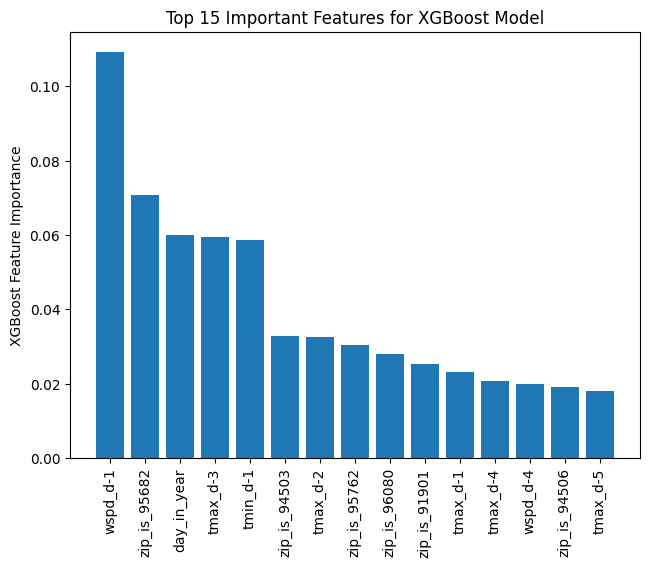

In [90]:
# Determine important features in XGBoost model
model_features  = np.concatenate((numeric_cols, zip_cols))
num_feat_imp = 15
#Extract indices of top num_feat_imp most important features
feature_indices = np.argpartition(best_model.feature_importances_, -num_feat_imp)[-num_feat_imp:][::-1]

plot_xy = {}
for i in range(len(feature_indices)):
    plot_xy[model_features[feature_indices[i]]] = best_model.feature_importances_[feature_indices[i]]

# print(model_features[feature_indices])
# print(plot_xy)
plot_xy = dict(sorted(plot_xy.items(), key=lambda item: item[1], reverse=True))

# Plot feature importances
fig, ax = plt.subplots()
# plt.bar(model_features[feature_indices], best_model.feature_importances_[feature_indices])
plt.bar(plot_xy.keys(), plot_xy.values())
fig.tight_layout()
ax.set_title("Top " + str(num_feat_imp) + " Important Features for XGBoost Model")
ax.set_ylabel("XGBoost Feature Importance")
plt.xticks(rotation=90)
plt.savefig("../data/predictions/xgb_feature_importance.png")
plt.show()

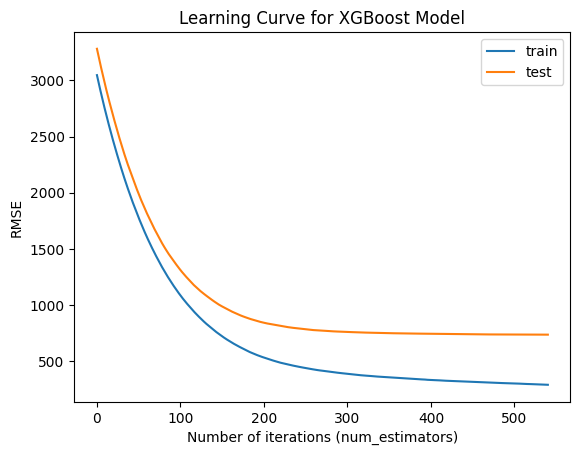

In [91]:
# Extract and plot learning curve over XGBoost training iterations
results = best_model.evals_result()
plt.plot(results['validation_0']['rmse'], label='train')
plt.plot(results['validation_1']['rmse'], label='test')
plt.legend()
plt.title("Learning Curve for XGBoost Model")
plt.ylabel("RMSE")
plt.xlabel("Number of iterations (num_estimators)")
plt.savefig("../data/predictions/xgb_learning_curve.png")
plt.show()